In [4]:
import pickle
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12.0,12.0]
%matplotlib inline

In [2]:
with open('./training_logs/mobileNet_classHist_alpha1.0_depth1.0_facies', 'rb') as hfile:
    classHist = pickle.load(hfile)
with open('./training_logs/mobileNet_top2Hist_alpha1.0_depth1.0_facies', 'rb') as hfile:
    top2Hist = pickle.load(hfile)

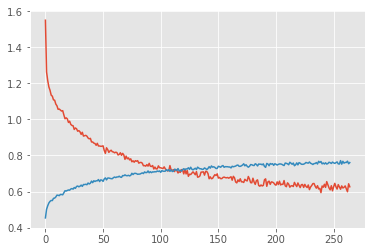

In [8]:
classLoss = classHist['loss']
classAcc = classHist['acc']

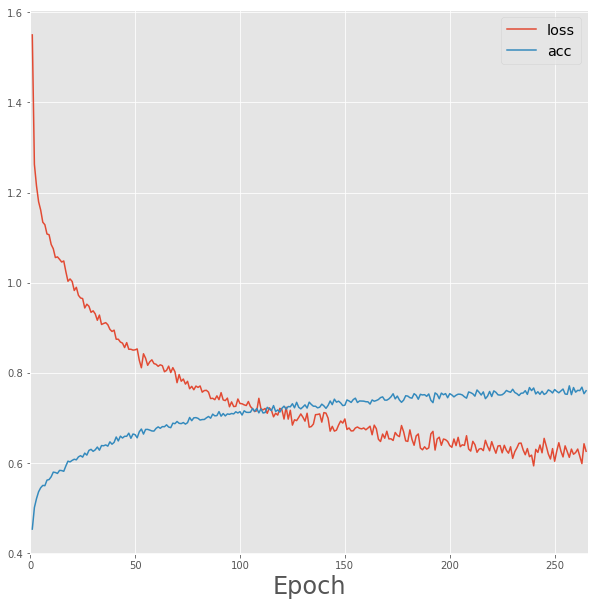

In [18]:
from coremdlr.utils.models_utils import make_training_fig

fig = make_training_fig(classHist, title='Classification Layers Training')
plt.show(fig)

In [19]:
plt.show(make_training_fig(top2Hist, title='(Attempted) Top 2 Conv Training'))

In [34]:
import numpy as np
import pickle

from keras import backend as K
from keras import utils
from keras.utils.training_utils import multi_gpu_model
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications import mobilenetv2
from keras.callbacks import EarlyStopping

from coremdlr.utils.facies_utils import make_labeled_frames
from coremdlr.utils.models_utils import mnet_idxs_above, save_keras_model, print_layers

In [35]:
img = np.load('./data/FULL_CORE_image_arr.npy')
class_labels = np.load('./data/FULL_CORE_facies_labels.npy')
n_classes = 9
metrics=['accuracy']

X_train, y_train = make_labeled_frames(img[:,152:248], class_labels, 96, stride=96, shuffle=True)

datagen = ImageDataGenerator(width_shift_range=0.1,
                            shear_range=-5.0,
                            zoom_range=0.05,
                            fill_mode='constant', cval=0.0,
                            horizontal_flip=True,
                            validation_split=0.2)

y_train = utils.to_categorical(y_train, n_classes)
datagen.fit(X_train)

Making  6327  patches...
At patch # 0
At patch # 6000
At patch # 3000
At patch # 1000
At patch # 2000
At patch # 5000
At patch # 4000
Label counts =  [(1, 417), (2, 316), (3, 287)]


In [38]:
split_idx = int(y_train.shape[0]*0.8)
print('Training label counts: ', np.sum(y_train[:split_idx, :], axis=0))
print('Validate label counts: ', np.sum(y_train[split_idx:, :], axis=0))

Training label counts:  [ 338.  259.  236. 1693. 1647.  208.  538.   75.   67.]
Validate label counts:  [ 79.  57.  51. 455. 421.  45. 120.  14.  24.]


In [40]:
# Build Model
mnet_base = mobilenetv2.MobileNetV2(include_top=False, weights='imagenet',
                                    input_shape=(96,96,3))
x = mnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=mnet_base.input, outputs=predictions)

# first train new top layers
for layer in mnet_base.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=metrics)

print("CURRENT TRAINABLE LAYERS:")
print_layers(model, only_trainable=True)

CURRENT TRAINABLE LAYERS:
150 global_average_pooling2d_1 True
151 dense_1 True
152 dense_2 True


In [41]:
epochs = 500
batch_size = 64
early_stop = EarlyStopping(monitor='loss', patience=25)
hist_1 = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train)/batch_size,
                    epochs=epochs,
                    callbacks=[early_stop], verbose=1)

with open('./training_logs/mobileNet_classHist_facies', 'wb') as hist_pickle:
        pickle.dump(hist_1.history, hist_pickle)

save_keras_model(model, './saved_models/mobileNet_classLayers_facies')

Epoch 1/500
99/98 [==============================] - 10s 96ms/step - loss: 1.4456 - acc: 0.4680
Epoch 2/500
99/98 [==============================] - 9s 91ms/step - loss: 1.2479 - acc: 0.5176
Epoch 3/500
99/98 [==============================] - 9s 91ms/step - loss: 1.1899 - acc: 0.5417
Epoch 4/500
99/98 [==============================] - 9s 90ms/step - loss: 1.1714 - acc: 0.5438
Epoch 5/500
99/98 [==============================] - 9s 91ms/step - loss: 1.1424 - acc: 0.5439
Epoch 6/500
99/98 [==============================] - 9s 90ms/step - loss: 1.1267 - acc: 0.5567
Epoch 7/500
99/98 [==============================] - 9s 91ms/step - loss: 1.0996 - acc: 0.5664
Epoch 8/500
99/98 [==============================] - 9s 90ms/step - loss: 1.1004 - acc: 0.5654
Epoch 9/500
99/98 [==============================] - 9s 89ms/step - loss: 1.0939 - acc: 0.5641
Epoch 10/500
99/98 [==============================] - 9s 92ms/step - loss: 1.0628 - acc: 0.5831
Epoch 11/500
99/98 [============================

99/98 [==============================] - 9s 90ms/step - loss: 0.7985 - acc: 0.6910
Epoch 87/500
99/98 [==============================] - 9s 89ms/step - loss: 0.7964 - acc: 0.6888
Epoch 88/500
99/98 [==============================] - 9s 92ms/step - loss: 0.7946 - acc: 0.6915
Epoch 89/500
99/98 [==============================] - 9s 89ms/step - loss: 0.8003 - acc: 0.6900
Epoch 90/500
99/98 [==============================] - 9s 89ms/step - loss: 0.7830 - acc: 0.6966
Epoch 91/500
99/98 [==============================] - 9s 89ms/step - loss: 0.7912 - acc: 0.6865
Epoch 92/500
99/98 [==============================] - 9s 90ms/step - loss: 0.7939 - acc: 0.6987
Epoch 93/500
99/98 [==============================] - 9s 89ms/step - loss: 0.7747 - acc: 0.7006
Epoch 94/500
99/98 [==============================] - 9s 89ms/step - loss: 0.7653 - acc: 0.6981
Epoch 95/500
99/98 [==============================] - 9s 89ms/step - loss: 0.7889 - acc: 0.6937
Epoch 96/500
99/98 [==============================] -

99/98 [==============================] - 9s 89ms/step - loss: 0.7356 - acc: 0.7252
Epoch 171/500
99/98 [==============================] - 9s 89ms/step - loss: 0.7378 - acc: 0.7233
Epoch 172/500
99/98 [==============================] - 9s 89ms/step - loss: 0.7022 - acc: 0.7325
Epoch 173/500
99/98 [==============================] - 9s 89ms/step - loss: 0.7395 - acc: 0.7172
Epoch 174/500
99/98 [==============================] - 9s 89ms/step - loss: 0.7170 - acc: 0.7252
Epoch 175/500
99/98 [==============================] - 9s 89ms/step - loss: 0.7171 - acc: 0.7245
Epoch 176/500
99/98 [==============================] - 9s 89ms/step - loss: 0.7129 - acc: 0.7328
Epoch 177/500
99/98 [==============================] - 9s 89ms/step - loss: 0.7336 - acc: 0.7224
Epoch 178/500
99/98 [==============================] - 9s 89ms/step - loss: 0.7343 - acc: 0.7293
Epoch 179/500
99/98 [==============================] - 9s 89ms/step - loss: 0.7239 - acc: 0.7340
Epoch 180/500
99/98 [=======================

99/98 [==============================] - 9s 89ms/step - loss: 0.7141 - acc: 0.7402
Epoch 255/500
99/98 [==============================] - 9s 89ms/step - loss: 0.7039 - acc: 0.7346
Epoch 256/500
99/98 [==============================] - 9s 88ms/step - loss: 0.6997 - acc: 0.7429
Epoch 257/500
99/98 [==============================] - 9s 90ms/step - loss: 0.6927 - acc: 0.7483
Epoch 258/500
99/98 [==============================] - 9s 90ms/step - loss: 0.6894 - acc: 0.7464
Epoch 259/500
99/98 [==============================] - 9s 88ms/step - loss: 0.6974 - acc: 0.7427
Epoch 260/500
99/98 [==============================] - 9s 89ms/step - loss: 0.7068 - acc: 0.7453
Epoch 261/500
99/98 [==============================] - 9s 88ms/step - loss: 0.6908 - acc: 0.7502
Epoch 262/500
99/98 [==============================] - 9s 89ms/step - loss: 0.7132 - acc: 0.7389
Epoch 263/500
99/98 [==============================] - 9s 89ms/step - loss: 0.6685 - acc: 0.7526
Epoch 264/500
99/98 [=======================

In [42]:
# Now train whole network
for layer in model.layers:
    layer.trainable = True

model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=metrics)

print("CURRENT TRAINABLE LAYERS:")
print_layers(model, only_trainable=True)

CURRENT TRAINABLE LAYERS:
0 input_1 True
1 Conv1 True
2 bn_Conv1 True
3 Conv1_relu True
4 expanded_conv_depthwise True
5 expanded_conv_depthwise_BN True
6 expanded_conv_depthwise_relu True
7 expanded_conv_project True
8 expanded_conv_project_BN True
9 block_1_expand True
10 block_1_expand_BN True
11 block_1_expand_relu True
12 block_1_depthwise True
13 block_1_depthwise_BN True
14 block_1_depthwise_relu True
15 block_1_project True
16 block_1_project_BN True
17 block_2_expand True
18 block_2_expand_BN True
19 block_2_expand_relu True
20 block_2_depthwise True
21 block_2_depthwise_BN True
22 block_2_depthwise_relu True
23 block_2_project True
24 block_2_project_BN True
25 block_2_add True
26 block_3_expand True
27 block_3_expand_BN True
28 block_3_expand_relu True
29 block_3_depthwise True
30 block_3_depthwise_BN True
31 block_3_depthwise_relu True
32 block_3_project True
33 block_3_project_BN True
34 block_4_expand True
35 block_4_expand_BN True
36 block_4_expand_relu True
37 block_4_d

In [43]:
epochs = 500
batch_size = 64 
early_stop = EarlyStopping(monitor='loss', patience=25)
hist_2 = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train)/batch_size,
                    epochs=epochs,
                    callbacks=[early_stop], verbose=1)

with open('./training_logs/mobileNet_fullHist_facies', 'wb') as hist_pickle:
        pickle.dump(hist_2.history, hist_pickle)
        
save_keras_model(model, './saved_models/mobileNet_fullNetwork_facies')

Epoch 1/500
99/98 [==============================] - 16s 159ms/step - loss: 1.7110 - acc: 0.4272
Epoch 2/500
99/98 [==============================] - 10s 98ms/step - loss: 1.3954 - acc: 0.4856
Epoch 3/500
99/98 [==============================] - 9s 96ms/step - loss: 1.2912 - acc: 0.5123
Epoch 4/500
99/98 [==============================] - 10s 96ms/step - loss: 1.2264 - acc: 0.5343
Epoch 5/500
99/98 [==============================] - 10s 98ms/step - loss: 1.1683 - acc: 0.5561
Epoch 6/500
99/98 [==============================] - 10s 98ms/step - loss: 1.1430 - acc: 0.5592
Epoch 7/500
99/98 [==============================] - 10s 98ms/step - loss: 1.1133 - acc: 0.5793
Epoch 8/500
99/98 [==============================] - 10s 97ms/step - loss: 1.0920 - acc: 0.5784
Epoch 9/500
99/98 [==============================] - 10s 101ms/step - loss: 1.0536 - acc: 0.5841
Epoch 10/500
99/98 [==============================] - 10s 98ms/step - loss: 1.0443 - acc: 0.5935
Epoch 11/500
99/98 [==================

99/98 [==============================] - 10s 104ms/step - loss: 0.1697 - acc: 0.9472
Epoch 85/500
99/98 [==============================] - 10s 103ms/step - loss: 0.1531 - acc: 0.9540
Epoch 86/500
99/98 [==============================] - 10s 105ms/step - loss: 0.1368 - acc: 0.9552
Epoch 87/500
99/98 [==============================] - 10s 105ms/step - loss: 0.1620 - acc: 0.9488
Epoch 88/500
99/98 [==============================] - 10s 105ms/step - loss: 0.1449 - acc: 0.9528
Epoch 89/500
99/98 [==============================] - 10s 99ms/step - loss: 0.1573 - acc: 0.9508
Epoch 90/500
99/98 [==============================] - 10s 103ms/step - loss: 0.1531 - acc: 0.9527
Epoch 91/500
99/98 [==============================] - 10s 105ms/step - loss: 0.1459 - acc: 0.9529
Epoch 92/500
99/98 [==============================] - 11s 107ms/step - loss: 0.1523 - acc: 0.9477
Epoch 93/500
99/98 [==============================] - 10s 105ms/step - loss: 0.1403 - acc: 0.9552
Epoch 94/500
99/98 [==============

99/98 [==============================] - 10s 102ms/step - loss: 0.1090 - acc: 0.9687
Epoch 167/500
99/98 [==============================] - 10s 99ms/step - loss: 0.0915 - acc: 0.9752
Epoch 168/500
99/98 [==============================] - 10s 100ms/step - loss: 0.0905 - acc: 0.9745
Epoch 169/500
99/98 [==============================] - 10s 102ms/step - loss: 0.0948 - acc: 0.9743
Epoch 170/500
99/98 [==============================] - 10s 101ms/step - loss: 0.0914 - acc: 0.9737
Epoch 171/500
99/98 [==============================] - 10s 99ms/step - loss: 0.1251 - acc: 0.9708
Epoch 172/500
99/98 [==============================] - 10s 99ms/step - loss: 0.1065 - acc: 0.9738
Epoch 173/500
99/98 [==============================] - 10s 100ms/step - loss: 0.0987 - acc: 0.9737
Epoch 174/500
99/98 [==============================] - 10s 100ms/step - loss: 0.0846 - acc: 0.9776
Epoch 175/500
99/98 [==============================] - 10s 99ms/step - loss: 0.1019 - acc: 0.9722
Epoch 176/500
99/98 [=======

99/98 [==============================] - 10s 103ms/step - loss: 0.0649 - acc: 0.9834
Epoch 250/500
99/98 [==============================] - 10s 102ms/step - loss: 0.0751 - acc: 0.9815
Epoch 251/500
99/98 [==============================] - 10s 101ms/step - loss: 0.0591 - acc: 0.9859
Epoch 252/500
99/98 [==============================] - 10s 103ms/step - loss: 0.0768 - acc: 0.9774
Epoch 253/500
99/98 [==============================] - 10s 102ms/step - loss: 0.0646 - acc: 0.9831
Epoch 254/500
99/98 [==============================] - 10s 102ms/step - loss: 0.0691 - acc: 0.98171s - loss: 0.0702 
Epoch 255/500
99/98 [==============================] - 10s 102ms/step - loss: 0.0724 - acc: 0.9807
Epoch 256/500
99/98 [==============================] - 10s 102ms/step - loss: 0.0703 - acc: 0.9810
Epoch 257/500
99/98 [==============================] - 10s 102ms/step - loss: 0.0790 - acc: 0.9810


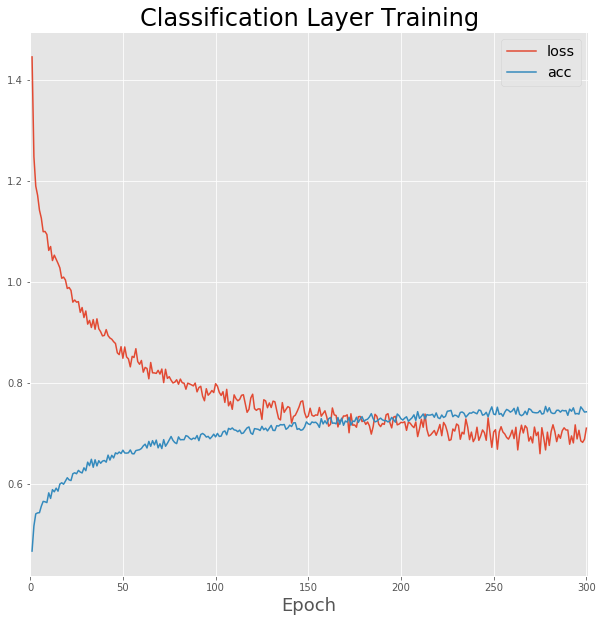

In [48]:
plt.show(make_training_fig(hist_1.history, title="Classification Layer Training"))

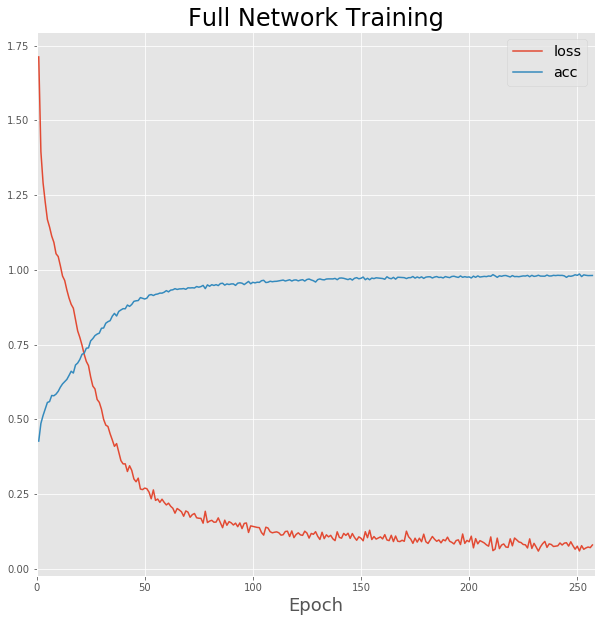

In [50]:
plt.show(make_training_fig(hist_2.history, title="Full Network Training"))

In [53]:
y_hat = model.predict_generator(datagen.flow(X_train, subset='validation'))
y_hat = np.argmax(y_hat, axis=1) + 1

In [59]:
y_true = (np.argmax(y_train, axis=1) + 1)[-y_hat.size:]

In [60]:
from sklearn.metrics import confusion_matrix

In [61]:
confusion_matrix(y_true, y_hat)

array([[  5,   5,   1,  18,  28,   0,  16,   2,   4],
       [  5,   6,   2,  13,  13,   1,  15,   0,   2],
       [  2,   3,   2,  11,  22,   1,   7,   2,   1],
       [ 26,  18,   6,  99, 183,  17,  86,   7,  12],
       [ 25,  13,   3, 103, 165,  11,  91,   5,   5],
       [  4,   0,   2,   5,  19,   5,   9,   0,   1],
       [  4,   9,   2,  24,  44,   4,  27,   5,   1],
       [  1,   1,   0,   7,   4,   1,   0,   0,   0],
       [  2,   0,   0,   4,  12,   1,   4,   0,   1]])

Confusion matrix, without normalization
[[ 51   0   0   4  13   2   9   0   0]
 [  0  57   0   0   0   0   0   0   0]
 [  4   0  14   7  12   4  10   0   0]
 [ 10   0   2 250 128   4  58   2   0]
 [  8   4   1  10 359   1  37   0   1]
 [  0   5   0   1   3  18  14   0   4]
 [  0   2   0   2   0   0 115   0   1]
 [  0   0   0   0   1   0   0  13   0]
 [  1   1   0   0   0   0   7   0  15]]
Normalized confusion matrix
[[0.65 0.   0.   0.05 0.16 0.03 0.11 0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.08 0.   0.27 0.14 0.24 0.08 0.2  0.   0.  ]
 [0.02 0.   0.   0.55 0.28 0.01 0.13 0.   0.  ]
 [0.02 0.01 0.   0.02 0.85 0.   0.09 0.   0.  ]
 [0.   0.11 0.   0.02 0.07 0.4  0.31 0.   0.09]
 [0.   0.02 0.   0.02 0.   0.   0.96 0.   0.01]
 [0.   0.   0.   0.   0.07 0.   0.   0.93 0.  ]
 [0.04 0.04 0.   0.   0.   0.   0.29 0.   0.62]]


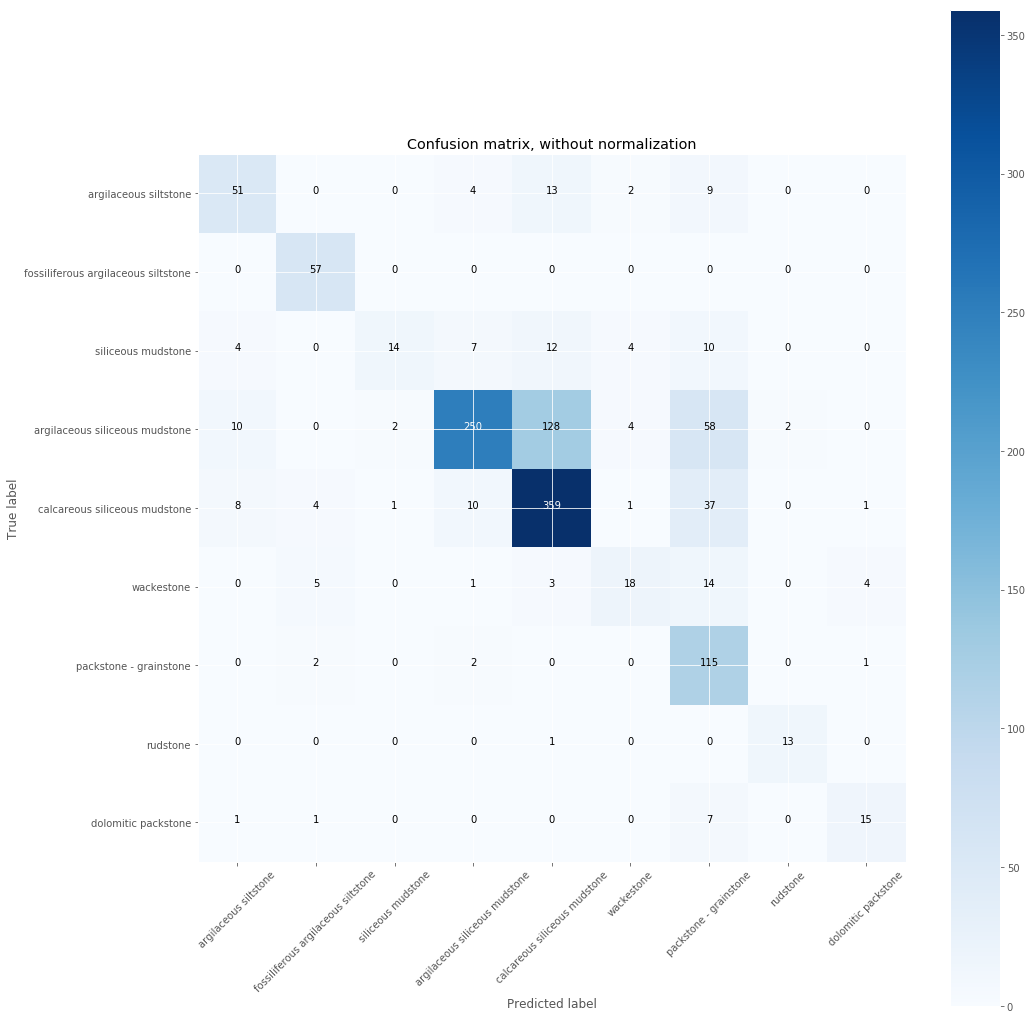

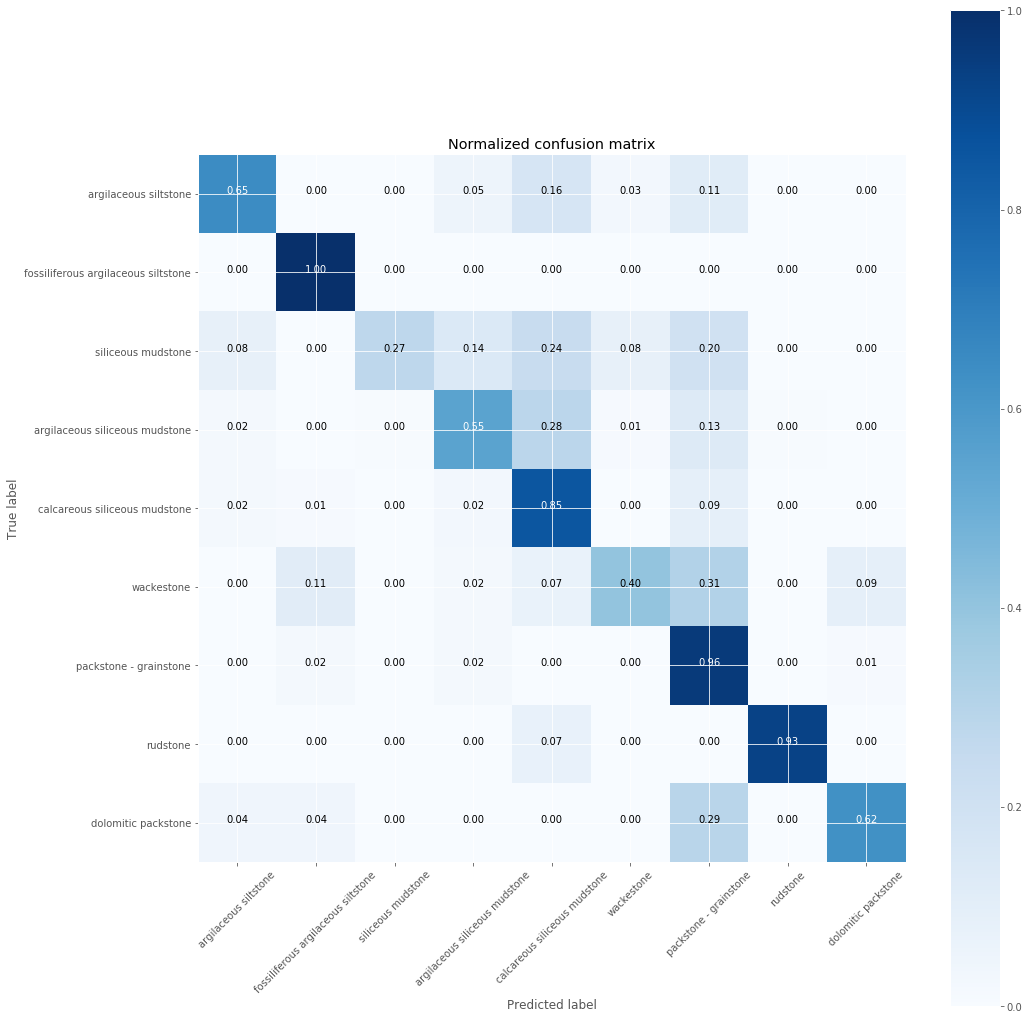

In [72]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

facies_names = ['argilaceous siltstone', 'fossiliferous argilaceous siltstone',
     'siliceous mudstone', 'argilaceous siliceous mudstone', 'calcareous siliceous mudstone',
     'wackestone', 'packstone - grainstone', 'rudstone', 'dolomitic packstone']

cnf_matrix = confusion_matrix(y_true, y_hat2)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=facies_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=facies_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [74]:
# Why is this only 70% when training acc reached 98% ???
sum(np.equal(y_true, y_hat2)) / y_hat2.size

0.7051383399209487